Find $u:\Omega \rightarrow \mathbb{R}$ satisfying
$$
\nabla \cdot (-\nabla u) + r(x) = 0
$$
on 
$$
\Omega = [0,1] \times [0,1]
$$
subject to
$$
n\cdot \nabla u|_{\partial \Omega} = g(x)
$$
$$
r(x)=-10e^{-\frac{(x-0.5)^2+(y-0.5)^2}{0.02}}
$$

In [9]:
import ipyparallel
import os
rc = ipyparallel.Client(profile="mpi")
view = rc[:]
view.apply(os.chdir, os.getcwd())
print view


<DirectView [0, 1]>


In [10]:
%%px
from mpi4py import MPI
mpi = MPI.COMM_WORLD
bcast = mpi.bcast
barrier = mpi.barrier
rank = mpi.rank
print "MPI rank: %i/%i" % (mpi.rank,mpi.size)

[stdout:0] MPI rank: 0/2
[stdout:1] MPI rank: 1/2


In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from proteus.iproteus import *
import proteus.default_p as physics 
import proteus.default_n as numerics
from proteus.TransportCoefficients import PoissonEquationCoefficients

In [12]:
def r(x):
    #return +2*x[...,0]*(1.0-x[...,0])+2*x[...,1]*(1.0-x[...,1])
    #return 1-x[...,0]
    return -10*np.exp(-((x[0]-0.5)**2+(x[1]-0.5)**2)/0.02)
def a(x):
    return np.array([[1.0,0.0],
                     [0.0,1.0]])
physics.coefficients = PoissonEquationCoefficients([a],[r]) 
physics.name="PoissonDots"

In [5]:
physics.nd = 2

# use structured mesh
physics.domain =  Domain.RectangularDomain(L=[1.0,1.0],
                                           x=[0.0,0.0])
all_bc_tags = [physics.domain.boundaryTags['left'],
                physics.domain.boundaryTags['top'],
                physics.domain.boundaryTags['right'],
                physics.domain.boundaryTags['bottom']]

def getDBC(x,flag):
    return
    if flag in all_bc_tags:
        return lambda x,t: 0.0
        
physics.dirichletConditions = {0:getDBC}


def getDFBC(x, flag):
        #if x[0] == 0:
    if flag in all_bc_tags:
        return lambda x,t: -np.sin(5*x[0])
    
physics.diffusiveFluxBoundaryConditions = {0:{0:getDFBC}}

In [6]:
numerics=default_n
numerics.femSpaces = {0:FemTools.P1}
numerics.elementQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd,3)
numerics.elementBoundaryQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd-1,3)
numerics.nn = 10


numerics.matrix = LinearAlgebraTools.SparseMatrix
numerics.multilevelLinearSolver = LinearSolvers.KSP_petsc4py
numerics.linearSmoother = None
numerics.l_atol_res = 1.0e-8
numerics.parallelPartitioningType = MeshTools.MeshParallelPartitioningTypes.node
numerics.nLayersOfOverlapForParallel =0

from petsc4py import PETSc
OptDB = PETSc.Options()
OptDB.setValue("ksp_type", "preonly")
OptDB.setValue("pc_type", "lu")
OptDB.setValue("pc_factor_mat_solver_package", "superlu_dist")
OptDB.setValue("ksp", "constant_null_space")



numerics.numericalFluxType = NumericalFlux.Diffusion_SIPG_exterior
so = default_so
so.name = physics.name
so.sList=[default_s]
so.tnList = [0,1]

In [7]:
ns = NumericalSolution.NS_base(so,[physics],[numerics],so.sList,opts)
failed = ns.calculateSolution('run1')
assert(not failed)

<IPython.core.display.Javascript object>


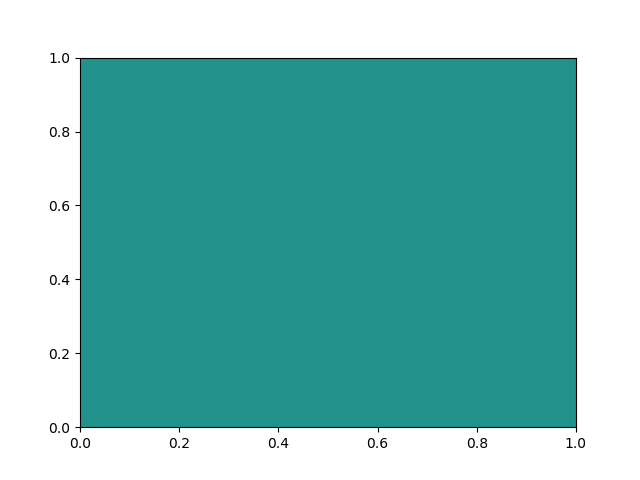

<IPython.core.display.Javascript object>


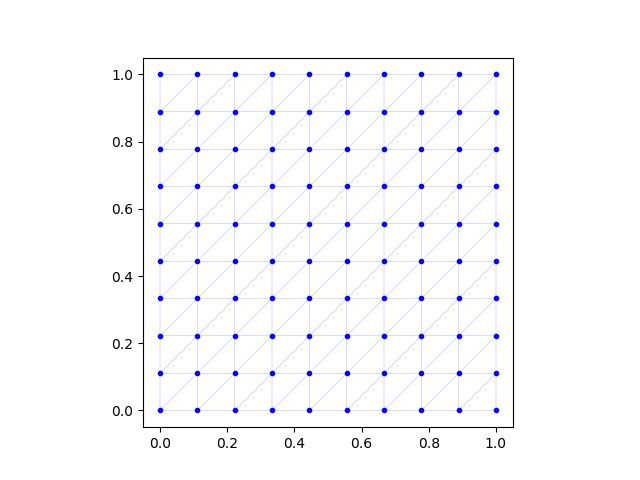

<IPython.core.display.Javascript object>


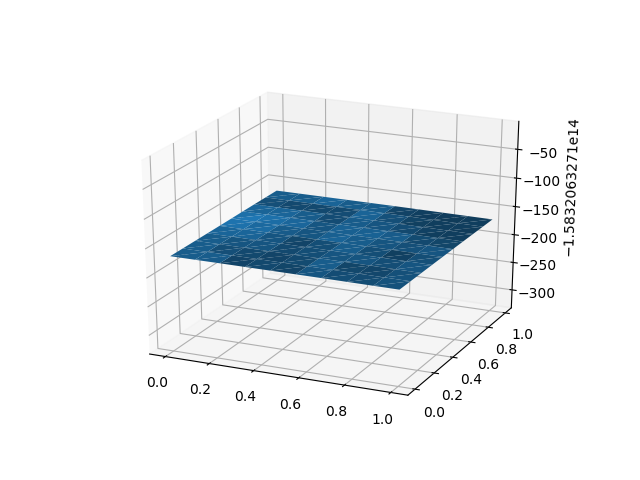

In [8]:
model = ns.modelList[0].levelModelList[-1]
plt.figure()
plt.tricontourf(model.mesh.nodeArray[:,0],
                model.mesh.nodeArray[:,1],
                model.mesh.elementNodesArray,
                model.u[0].dof)

import matplotlib.tri as tri
# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = tri.Triangulation(model.mesh.nodeArray[:,0],
                          model.mesh.nodeArray[:,1],
                          model.mesh.elementNodesArray)
plt.figure()
plt.gca().set_aspect('equal')
plt.triplot(triang, 'b.-', lw=0.1)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(triang, model.u[0].dof)